In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph
from sklearn.datasets import load_digits # this is used for import the dataset
from sklearn.model_selection import train_test_split # to split the data into␣ two parts
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.preprocessing import OneHotEncoder # for one hot encoding
import optuna # for hyperparameter tuning
import warnings # this is used for ignoring the warnings
warnings.filterwarnings("ignore")


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NN Class

- Constructor (__init__): Initializes the network with the specified input, hidden, and output sizes. It sets up the weights and biases for both layers and prepares lists to track training and testing loss over iterations.
- __str__ Method: Provides a simple string representation of the network's architecture, including the sizes of the input, hidden, and output layers, as well as the loss function in use.
- forward Method: Implements forward propagation through the network using the input data. It calculates the activations of the hidden layer and the output layer, applying the sigmoid function or softmax function based on the loss function specified.
- backward Method: Executes the backpropagation algorithm. It computes the gradient of the loss function with respect to each parameter in the network (weights and biases) and updates these parameters using the calculated gradients and the specified learning rate.
- sigmoid and sigmoid_derivative Methods: The sigmoid activation function and its derivative, used in both forward propagation (to calculate activations) and backpropagation (to calculate gradients).
- softmax Method: A softmax activation function that converts the output layer's activations into probabilities for classification tasks. It's used when the loss function is set to 'categorical_crossentropy'.

In [2]:
import numpy as np

class NeuralNetwork:
    """
    A simple neural network with one hidden layer.
    Parameters:
    -----------
    input_size: int
        The number of input features
    hidden_size: int
        The number of neurons in the hidden layer
    output_size: int
        The number of neurons in the output layer
    loss_func: str
        The loss function to use. Options are 'mse' for mean squared error,
        'log_loss' for logistic loss, and 'categorical_crossentropy' for categorical
        crossentropy.
    """
    def __init__(self, input_size, hidden_size, output_size, loss_func='mse'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_func = loss_func
        # Initialize weights and biases
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.bias1 = np.zeros((1, self.hidden_size))
        self.weights2 = np.random.randn(self.hidden_size, self.output_size)
        self.bias2 = np.zeros((1, self.output_size))
        # track loss
        self.train_loss = []
        self.test_loss = []
    
    def __str__(self):
        """
        Print the neural network architecture.
        """
        return f"Neural Network Layout:\nInput Layer: {self.input_size} neurons\nHidden Layer: {self.hidden_size} neurons\nOutput Layer: {self.output_size} neurons\nLoss Function: {self.loss_func}"

    def forward(self, X):
        """
        Perform forward propagation.
        Parameters:
        -----------
        X: numpy array
            The input data
        Returns:
        --------
        numpy array
            The predicted output
        """
        # Perform forward propagation
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        if self.loss_func == 'categorical_crossentropy':
            self.a2 = self.softmax(self.z2)
        else:
            self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, learning_rate):
        """
        Perform backpropagation.
        Parameters:
        -----------
        X: numpy array
            The input data
        y: numpy array
            The target output
        learning_rate: float
            The learning rate
        """
        # Perform backpropagation
        m = X.shape[0]
        # Calculate gradients
        if self.loss_func == 'mse':
            self.dz2 = self.a2 - y
        elif self.loss_func == 'log_loss':
            self.dz2 = -(y / self.a2 - (1 - y) / (1 - self.a2))
        elif self.loss_func == 'categorical_crossentropy':
            self.dz2 = self.a2 - y
        else:
            raise ValueError('Invalid loss function')
        
        self.dw2 = (1 / m) * np.dot(self.a1.T, self.dz2)
        self.db2 = (1 / m) * np.sum(self.dz2, axis=0, keepdims=True)
        self.dz1 = np.dot(self.dz2, self.weights2.T) * self.sigmoid_derivative(self.a1)
        self.dw1 = (1 / m) * np.dot(X.T, self.dz1)
        self.db1 = (1 / m) * np.sum(self.dz1, axis=0, keepdims=True)
        
        # Update weights and biases
        self.weights2 -= learning_rate * self.dw2
        self.bias2 -= learning_rate * self.db2
        self.weights1 -= learning_rate * self.dw1
        self.bias1 -= learning_rate * self.db1

    def sigmoid(self, x):
        """
        Sigmoid activation function.
        Parameters:
        -----------
        x: numpy array
            The input data
        Returns:
        --------
        numpy array
            The output of the sigmoid function
        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """
        Derivative of the sigmoid activation function.
        Parameters:
        -----------
        x: numpy array
            The input data
        Returns:
        --------
        numpy array
            The output of the derivative of the sigmoid function
        """
        return x * (1 - x)

    def softmax(self, x):
        """
        Softmax activation function.
        Parameters:
        -----------
        x: numpy array
            The input data
        Returns:
        --------
        numpy array
            The output of the softmax function
        """
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)


# Trainer Class

- Constructor (__init__): Sets up the trainer with a neural network model and specifies the loss function to be used. It initializes lists to keep track of training and test loss, which can be useful for analyzing the model's performance over time.

- calculate_loss Method: Depending on the chosen loss function (mse, log_loss, or categorical_crossentropy), this method calculates and returns the loss between the predicted outputs and the true labels. This flexibility allows the neural network to be applicable to different types of problems, such as regression (mse) and classification (log_loss and categorical_crossentropy).

- train Method: This is the core of the Trainer class, where the actual training happens. It performs the forward pass to calculate predictions, the backward pass to update the model's weights based on the loss gradient, and then calculates both training and test loss at the end of each epoch. Tracking the loss across epochs is essential for monitoring the model's learning progress and diagnosing issues like overfitting or underfitting.

In [3]:
import numpy as np

class Trainer:
    """
    A class to train a neural network.
    Parameters:
    -----------
    model: NeuralNetwork
        The neural network model to train
    loss_func: str
        The loss function to use. Options are 'mse' for mean squared error,
        'log_loss' for logistic loss, and 'categorical_crossentropy' for categorical
        crossentropy.
    """
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.test_loss = []

    def calculate_loss(self, y_true, y_pred):
        """
        Calculate the loss

        Parameters:
        -----------
        y_true: numpy array
            The true output
        y_pred: numpy array
            The predicted output
        Returns:
        --------
        float
            The loss
        """
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true) ** 2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true * np.log(y_pred))
        else:
            raise ValueError('Invalid loss function')

    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate):
        """
        Train the neural network.

        Parameters:
        -----------
        X_train: numpy array
            The training input data
        y_train: numpy array
            The training target output
        X_test: numpy array
            The test input data
        y_test: numpy array
            The test target output
        epochs: int
            The number of epochs to train the model
        learning_rate: float
            The learning rate
        """
        for _ in range(epochs):
            self.model.forward(X_train)
            self.model.backward(X_train, y_train, learning_rate)
            train_loss = self.calculate_loss(y_train, self.model.a2)
            self.train_loss.append(train_loss)

            self.model.forward(X_test)
            test_loss = self.calculate_loss(y_test, self.model.a2)
            self.test_loss.append(test_loss)


# Load Dataset

This block of code is designed to visualize the first 10 images of the digits dataset from sklearn.datasets. The digits dataset consists of 8x8 pixel images of handwritten digits (0 through 9), making it a popular dataset for testing and demonstrating image classification algorithms, especially in educational settings.

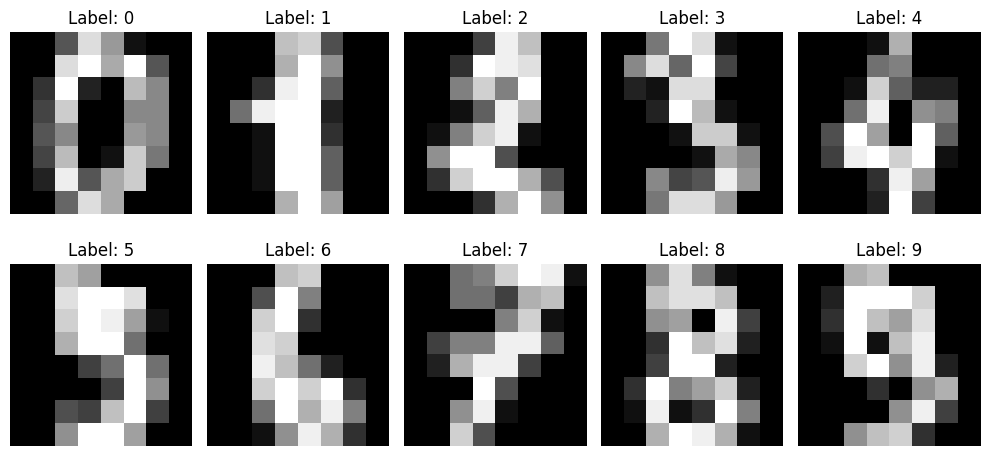

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Plot the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {digits.target[i]}")

plt.tight_layout()
plt.show()


# Mini Preprocessing

- MinMaxScaler() is instantiated to scale the pixel values of the images. The MinMaxScaler scales the data to a default range of 0 to 1, which is a common practice in neural network models as it can help with faster convergence during the training process.
- X = scaler.fit_transform(digits.data) scales the digits.data (which contains the flattened pixel values for each image) and assigns the scaled data back to X. This step ensures that all features (pixel values, in this case) are on a similar scale.

- The target output y = digits.target is simply the digit values that each image represents. These are integers ranging from 0 to 9.
- OneHotEncoder(sparse=False) is used to convert these integer targets into one-hot encoded arrays. One-hot encoding is essential for classification models where the output needs to be a probability distribution across several classes. The sparse=False argument is specified to ensure that the encoder returns a dense array instead of a sparse matrix, which is the default.
- y_onehot = encoder.fit_transform(y.reshape(-1, 1)) transforms the target array y into a one-hot encoded version. The reshape(-1, 1) is necessary because fit_transform expects a 2D array as input, so the target array is reshaped from 1D (n_samples,) to 2D (n_samples, 1).

- train_test_split(X, y_onehot, test_size=0.2, random_state=42) is used to split the dataset into training and testing sets. test_size=0.2 indicates that 20% of the data should be allocated to the test set, and the rest to the training set. The random_state parameter ensures that the split is reproducible; using the same seed (42 in this case) will produce the same split across different runs.
- The split returns four arrays: X_train and y_train for training data and targets, and X_test and y_test for testing data and targets. This setup is standard for supervised learning tasks, where a model is trained on one subset of the data and then tested on a separate subset to evaluate its performance.

In [6]:
# Preprocess the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(digits.data)
y = digits.target
# One-hot encode the target output
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)



# Creating Neural Net

This block of code sets up the foundation for training a neural network on the preprocessed digits dataset. Here's a breakdown of each step:

## 1. Defining Network Parameters:
- input_size = X.shape[1] sets the input size of the neural network to the number of features in the dataset. Since X contains flattened images from the digits dataset, X.shape[1] corresponds to the total number of pixels in each image.
- hidden_size = 64 defines the size of the hidden layer with 64 neurons. This is a design choice that can significantly impact the network's ability to learn complex patterns.
- output_size = len(np.unique(y)) determines the number of neurons in the output layer, which should match the number of unique classes in the dataset. np.unique(y) returns the unique values in the target array y, and len() counts these unique values. For the digits dataset, this will be 10 (digits 0-9).
- loss_func = 'categorical_crossentropy' specifies the loss function to use during training. Since this is a classification problem with multiple classes, categorical crossentropy is an appropriate choice as it measures the distance between the predicted probability distribution and the actual distribution (one-hot encoded targets).
## 2. Instantiating the Neural Network:
- nn = NeuralNetwork(input_size, hidden_size, output_size, loss_func) creates an instance of the NeuralNetwork class with the specified parameters. This step initializes the weights and biases of the network and sets it up for training.
3. Printing the Network Architecture:
- print(nn) calls the __str__ method of the NeuralNetwork class, which prints a summary of the network's architecture. This includes the number of neurons in the input, hidden, and output layers, as well as the loss function being used.

In [7]:
# Create an instance of the NeuralNetwork class
input_size = X.shape[1]
hidden_size = 64
output_size = len(np.unique(y))
loss_func = 'categorical_crossentropy'
epochs = 1000
learning_rate = 0.1
nn = NeuralNetwork(input_size, hidden_size, output_size, loss_func)
# Print the neural network artchitecture
print(nn)


Neural Network Layout:
Input Layer: 64 neurons
Hidden Layer: 64 neurons
Output Layer: 10 neurons
Loss Function: categorical_crossentropy


# Training and Evaluating Neural Net


In [8]:
trainer = Trainer(nn, loss_func)
trainer.train(X_train, y_train, X_test, y_test, epochs, learning_rate)
# Convert y_test from one-hot encoding to labels
y_test_labels = np.argmax(y_test, axis=1)
# Evaluate the performance of the neural network
predictions = np.argmax(nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 93.33%


# Plot loss

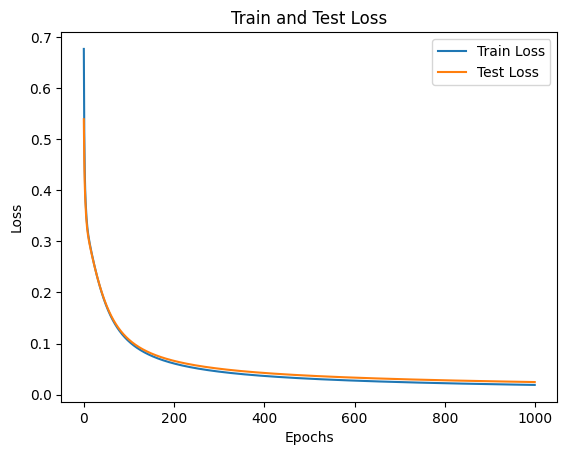

In [9]:
 plt.plot(trainer.train_loss, label='Train Loss')
plt.plot(trainer.test_loss, label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


 # Fine-Tune NN

The objective function is designed for hyperparameter optimization using Optuna, a hyperparameter optimization framework. This function aims to find the best set of hyperparameters for the neural network model to maximize its accuracy on the test dataset. Here's a detailed explanation of the function and its components:

### Objective Function:
- Purpose: The objective function's goal is to train the neural network with various hyperparameters and evaluate its performance, returning the accuracy as the objective value to be maximized.
### Hyperparameters:
- hidden_size: The number of neurons in the hidden layer. Optuna searches for the best size within a range of 32 to 128 neurons.
- learning_rate: The rate at which the neural network learns during training. A loguniform distribution is used to search between 1e-4 and 1e-1, allowing for a wide range of learning rates that can vary by orders of magnitude.
- epochs: The number of times the training dataset is passed through the neural network. The search range is from 500 to 10,000 epochs.
### Neural Network Training:
- A new instance of the NeuralNetwork class is created with the current trial's suggested hyperparameters.
- The Trainer class instance trains this neural network on the training dataset and evaluates it on the test dataset.
### Performance Evaluation:
- After training, the function evaluates the neural network's performance by predicting the test dataset and calculating the accuracy.
- The accuracy is then returned as the objective value, which Optuna will attempt to maximize over multiple trials.
### Optuna Study:
- An Optuna study object is created with the intention of maximizing the objective function.
- The study.optimize method is called with the objective function and the number of trials to perform (n_trials=10), initiating the optimization process.
### Results:
- After the optimization process, the function prints the hyperparameters of the best trial along with the best accuracy achieved.
- This information is crucial for understanding which hyperparameters led to the best performance of the neural network and can be used to configure the model for further training or operational deployment.

In [10]:
def objective(trial):
    # Define hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    epochs = trial.suggest_int('epochs', 500, 10000)
    
    # Create and train the neural network
    nn = NeuralNetwork(input_size, hidden_size, output_size, loss_func)
    trainer = Trainer(nn, loss_func)
    trainer.train(X_train, y_train, X_test, y_test, epochs, learning_rate)
    
    # Evaluate the performance of the neural network
    predictions = np.argmax(nn.forward(X_test), axis=1)
    accuracy = np.mean(predictions == y_test_labels)
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")
print(f"Best value: {study.best_trial.value}")

[I 2024-04-03 17:32:52,586] A new study created in memory with name: no-name-97b764a6-55ad-40fe-a380-1070dfe2dd3c
[I 2024-04-03 17:33:20,118] Trial 0 finished with value: 0.4166666666666667 and parameters: {'hidden_size': 51, 'learning_rate': 0.0014413194613866439, 'epochs': 5510}. Best is trial 0 with value: 0.4166666666666667.
[I 2024-04-03 17:33:38,566] Trial 1 finished with value: 0.6194444444444445 and parameters: {'hidden_size': 64, 'learning_rate': 0.0033275137442426374, 'epochs': 2763}. Best is trial 1 with value: 0.6194444444444445.
[I 2024-04-03 17:34:42,210] Trial 2 finished with value: 0.7305555555555555 and parameters: {'hidden_size': 90, 'learning_rate': 0.0018109191826480024, 'epochs': 6769}. Best is trial 2 with value: 0.7305555555555555.
[I 2024-04-03 17:35:08,102] Trial 3 finished with value: 0.4388888888888889 and parameters: {'hidden_size': 34, 'learning_rate': 0.0013651980096333098, 'epochs': 6263}. Best is trial 2 with value: 0.7305555555555555.
[I 2024-04-03 17:3

Best trial: {'hidden_size': 33, 'learning_rate': 0.04542062930913286, 'epochs': 737}
Best value: 0.7805555555555556


# Predict

In [11]:
best_nn = NeuralNetwork(input_size, study.best_trial.params['hidden_size'],output_size, loss_func)
best_trainer = Trainer(best_nn, loss_func)
best_trainer.train(X_train, y_train, X_test, y_test, study.best_trial.params['epochs'], study.best_trial.params['learning_rate'])
# Evaluate the performance of the best neural network
predictions = np.argmax(best_nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Best accuracy: {accuracy:.2%}")

Best accuracy: 78.33%


# Confusion Matrix

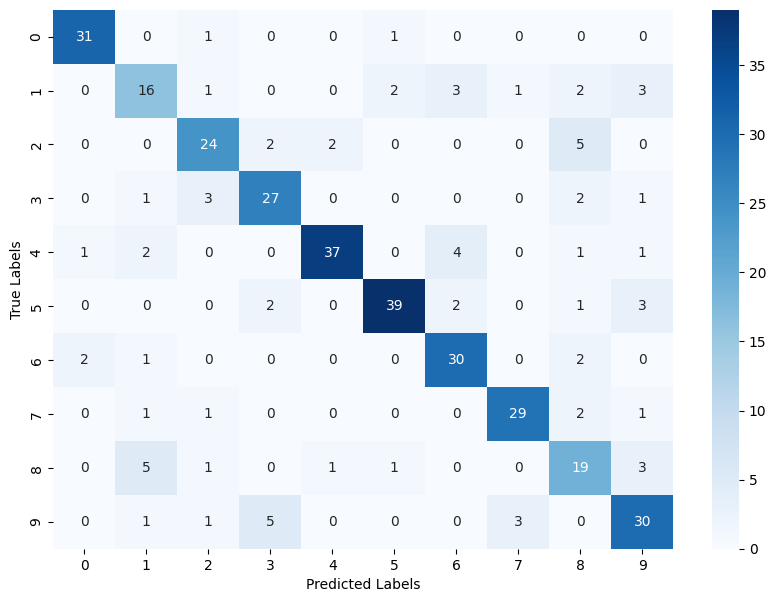

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
predictions = np.argmax(best_nn.forward(X_test), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# ROC Curve and AUC
For binary classification problems, ROC curves and AUC (Area Under the Curve) scores are invaluable. For multi-class classification, we can plot ROC curves for each class against all others.

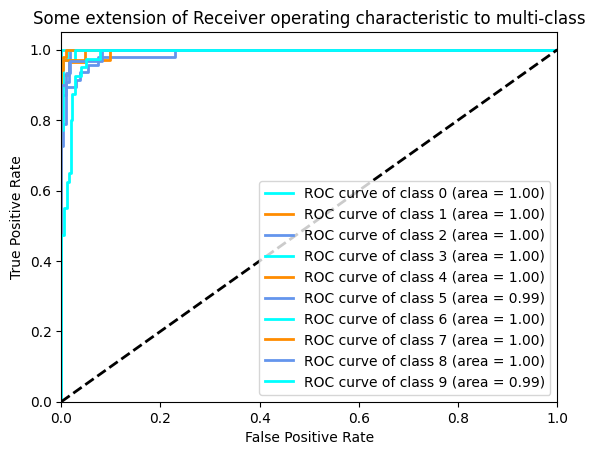

In [14]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_onehot.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], nn.forward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



# Error Analysis

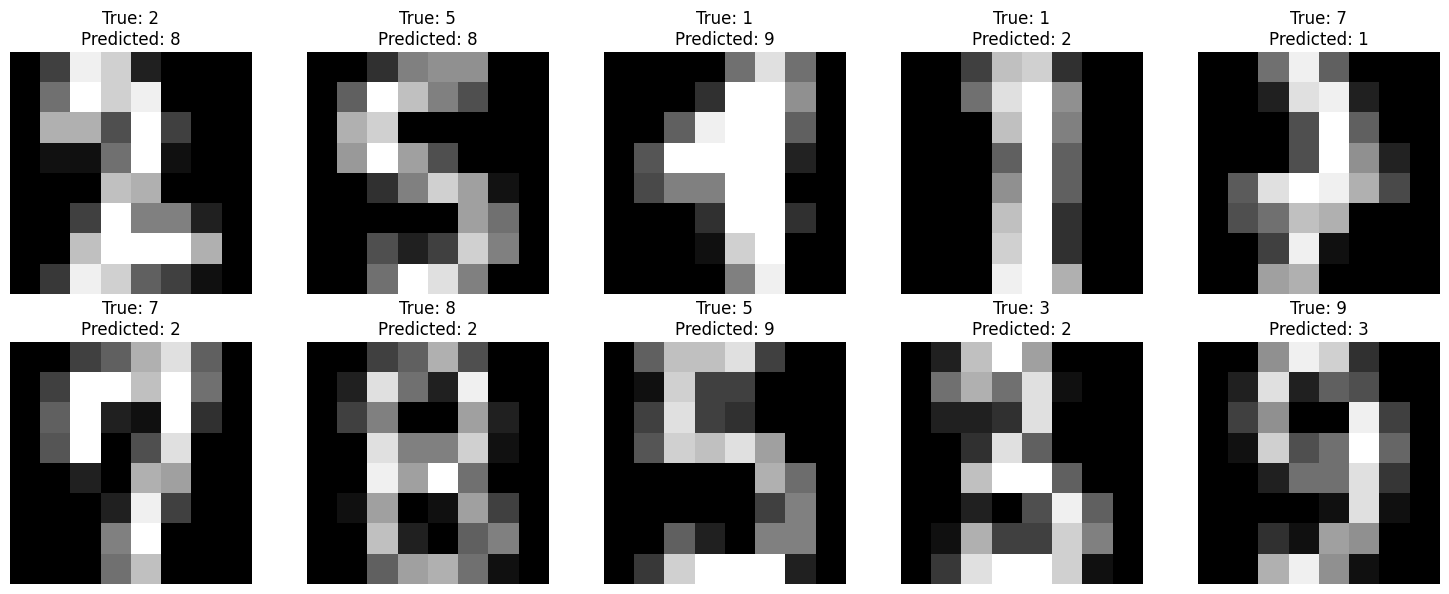

In [15]:
# Find misclassified examples
misclassified_idx = np.where(predictions != y_test_labels)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=False)

# Plot misclassified examples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(X_test[sample_idx[i]].reshape(8, 8), cmap='gray')
    ax.set_title(f'True: {y_test_labels[sample_idx[i]]}\nPredicted: {predictions[sample_idx[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()
